In [1]:
### test
import numpy as np
import os
import glob
from tensorflow.python.client import device_lib
import tensorflow as tf
# print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import numpy as np
from tqdm import tqdm
import os
import glob  # glob 라이브러리 추가
import pickle


# dataset 폴더 경로 설정
# PATH = '/content/drive/MyDrive/LAB/Sign_Language_Remaster/code/lstm/dataset'
PATH = r'C:\Users\oem\Desktop\jhy\dataset2'

# dataset 폴더 아래의 모든 폴더 목록을 얻기
actions = []  # 변경된 부분
label_mapping = {}  # 변경된 부분

### 액션 리스트 확인
for folder in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, folder)):
        # 각 폴더에 있는 npy 파일들을 확인
        npy_files = glob.glob(os.path.join(PATH, folder, 'seq_*.npy'))
        # 특정 조건에 맞는 npy 파일이 존재하면 actions와 label_mapping에 추가
        if npy_files:
            actions.append(folder)
            label_mapping[folder] = len(actions) - 1
print(len(actions), actions)

# 리스트를 파일로 저장
with open(r'C:\Users\oem\Desktop\jhy\signlanguage\Sign_Language_Remaster\logs\act_list.pkl', 'wb') as f:
    pickle.dump(actions, f)
data = []
labels = []




for action in tqdm(actions):
    PATH2 = os.path.join(PATH, action) #/dataset/{action}
    file_path = glob.glob(os.path.join(PATH2, f'seq_*.npy'))[0]
    try:
        loaded_data = np.load(file_path, allow_pickle=True).astype(np.float16)
        data.append(loaded_data)

        label = np.full((loaded_data.shape[0],), label_mapping[action])
        labels.append(label)
    except FileNotFoundError:
        print(f"File not found for action: {action}")

x_data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)

from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))


np.savez_compressed(r'C:\Users\oem\Desktop\jhy\array\XData.npz',x_data)
np.savez_compressed(r'C:\Users\oem\Desktop\jhy\array\YData.npz',y_data)

Num GPUs Available:  4
9 ['(Hat)', '(It is impossible)', "(it's raining", '(Liver to food)', '(Mouth) close', 'Farm', 'help', 'want', 'we']


100%|██████████| 9/9 [00:00<00:00,  9.66it/s]


In [1]:
# 저장파일 불러오기
import numpy as np
import tensorflow as tf
x_data = np.load(r'C:\Users\oem\Desktop\jhy\array\XData.npz')
y_data = np.load(r'C:\Users\oem\Desktop\jhy\array\YData.npz')
x_data = x_data['arr_0']
y_data = y_data['arr_0']

import pickle
with open(r'C:\Users\oem\Desktop\jhy\signlanguage\Sign_Language_Remaster\logs\act_list.pkl', 'rb') as file:
    # 리스트 로드
    actions = pickle.load(file)
    print(len(actions),'개의 액션이 저장되어있습니다.')

1439 개의 액션이 저장되어있습니다.


In [2]:
from sklearn.model_selection import train_test_split
# data를 train과 test로 나눔
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

DATA_CUT = 8
# 데이터 자르기
if DATA_CUT:
    x_train = x_train[::DATA_CUT]
    y_train = y_train[::DATA_CUT]
    # x_test = x_test[::DATA_CUT]
    # y_test = y_test[::DATA_CUT]
# x_train, x_test, y_train, y_test의 크기 확인
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
import sys

print('x_train size :',sys.getsizeof(x_train))
print('y_train size :',sys.getsizeof(y_train))

# 메모리 정리
x_data, y_data = 0,0

x_train shape: (16143, 30, 156)
y_train shape: (16143, 9)
x_test shape: (1794, 30, 156)
y_test shape: (1794, 9)
x_train size : 151098624
y_train size : 581276


In [3]:
# model 3 without strategy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=x_train.shape[1:3]),
    Dropout(0.5),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.5),
    LSTM(32, activation='tanh'),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           145920    
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 256)               8448      
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:
#model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(2048, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2048)              18063360  
                                                                 
 dense (Dense)               (None, 1439)              2948511   
                                                                 
Total params: 21,011,871
Trainable params: 21,011,871
Non-trainable params: 0
_________________________________________________________________


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

EPOCHS = 50
BATCH_SIZE = 0

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    # batch_size=BATCH_SIZE,
    shuffle = False,
    # callbacks=[
    #     ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
    #     ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    # ]
)
VERSION = 100
# VERSION = 43
MODEL_NAME = f'lstm_test{VERSION}_{len(actions)}act_e{EPOCHS}_C{DATA_CUT}_B{BATCH_SIZE}'
model.save(f'C:/Users/oem/Desktop/jhy/signlanguage/Sign_Language_Remaster/model/{MODEL_NAME}.h5')
print('model saved!')
##adsasdf

Epoch 1/50
505/505 [==============================] - 21s 25ms/step - loss: 0.1670 - acc: 0.9622 - val_loss: 0.0364 - val_acc: 0.9900
Epoch 2/50
505/505 [==============================] - 11s 23ms/step - loss: 0.0281 - acc: 0.9918 - val_loss: 0.0060 - val_acc: 0.9983
Epoch 3/50
505/505 [==============================] - 11s 23ms/step - loss: 0.0168 - acc: 0.9945 - val_loss: 0.0414 - val_acc: 0.9855
Epoch 4/50
505/505 [==============================] - 12s 23ms/step - loss: 0.0318 - acc: 0.9908 - val_loss: 0.0129 - val_acc: 0.9961
Epoch 5/50
505/505 [==============================] - 11s 22ms/step - loss: 0.0127 - acc: 0.9964 - val_loss: 0.0018 - val_acc: 0.9989
Epoch 6/50
505/505 [==============================] - 11s 23ms/step - loss: 0.0144 - acc: 0.9963 - val_loss: 0.0347 - val_acc: 0.9894
Epoch 7/50
505/505 [==============================] - 11s 22ms/step - loss: 0.0115 - acc: 0.9969 - val_loss: 7.5710e-04 - val_acc: 1.0000
Epoch 8/50
505/505 [==============================] - 11s 

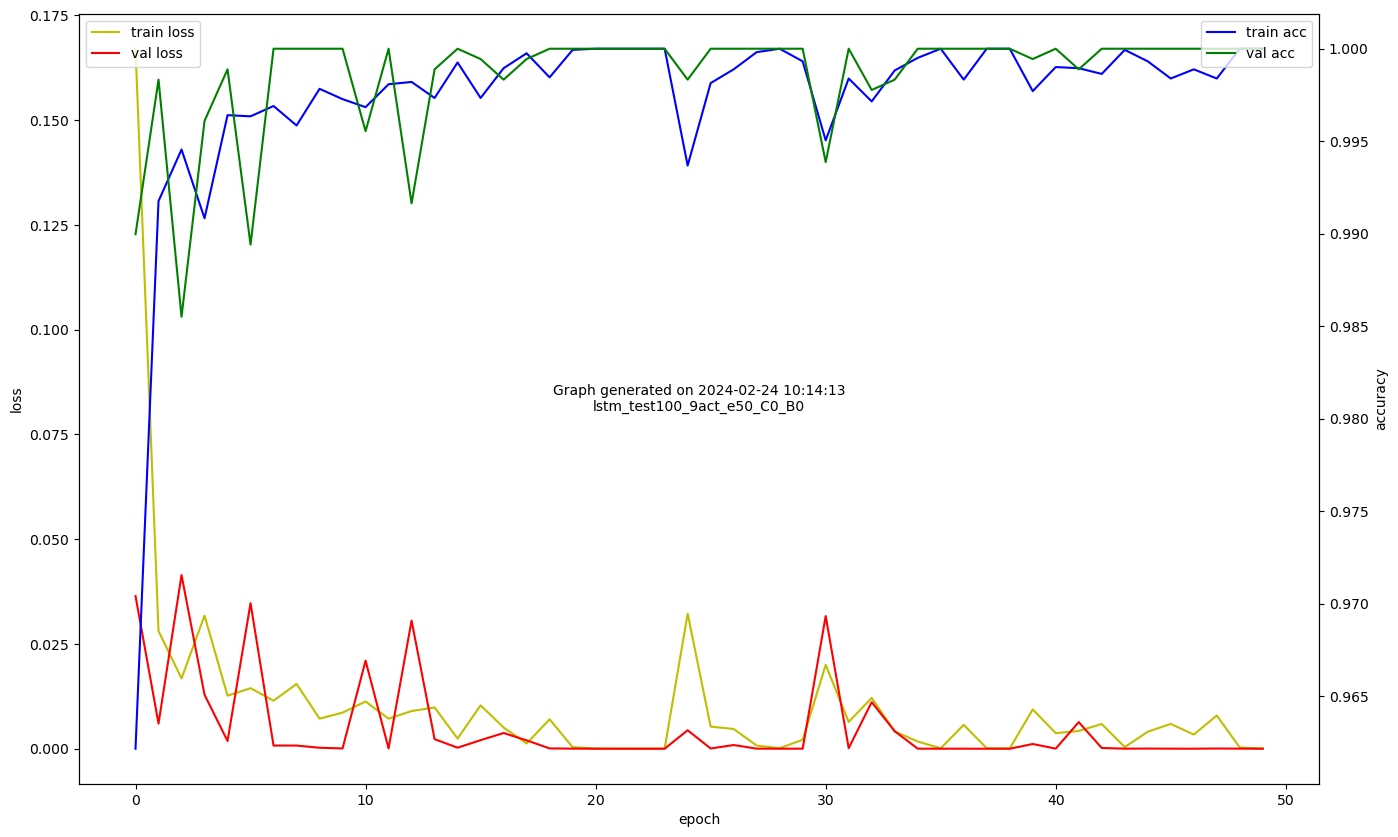

In [5]:
import matplotlib.pyplot as plt
from datetime import datetime
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')


now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")
plt.text(0.5, 0.5, f"Graph generated on {current_time}\n{MODEL_NAME}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig(f'{MODEL_NAME}.png')
plt.show()

In [7]:
1036073 / 400

2590.1825